# **0. Initial Setup and Library Imports**

In [ ]:
pip install dython

In [ ]:
# Standard library
from datetime import datetime
import math
import warnings

# Data handling
import numpy as np
import pandas as pd

# Statistics / scientific
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, kruskal
from dython.nominal import associations

# Scikit-learn (preprocessing, dimension reduction, clustering, embedding)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Visualization (matplotlib + seaborn)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
import seaborn as sns

# Misc settings
warnings.filterwarnings("ignore")

In [ ]:
!mkdir -p /usr/share/fonts/truetype/poppins
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf -P /usr/share/fonts/truetype/poppins/
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf -P /usr/share/fonts/truetype/poppins/
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Italic.ttf -P /usr/share/fonts/truetype/poppins/

font_dir = '/usr/share/fonts/truetype/poppins'
for font_file in fm.findSystemFonts(fontpaths=[font_dir]):
    fm.fontManager.addfont(font_file)

In [ ]:
formatter = FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M')
palette = ['#496af1', '#BFBFBF', '#e6e51e', '#4a4a4a']

plt.rcParams['font.family'] = 'Poppins'

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['text.color'] = '#808080'
plt.rcParams['axes.labelcolor'] = '#808080'
plt.rcParams['axes.titlecolor'] = '#808080'
plt.rcParams['xtick.labelcolor'] = '#808080'
plt.rcParams['ytick.labelcolor'] = '#808080'

plt.rcParams['xtick.color'] = '#BFBFBF'
plt.rcParams['ytick.color'] = '#BFBFBF'
plt.rcParams['axes.edgecolor'] = '#BFBFBF'
plt.rcParams['grid.color'] = '#BFBFBF'

gray_props = {
    "boxprops": dict(color="#808080"),
    "medianprops": dict(color="#808080"),
    "whiskerprops": dict(color="#808080"),
    "capprops": dict(color="#808080"),
    "flierprops": dict(marker='o', markeredgecolor="#808080", markersize=5)
}

# **1. Data Loading**

In [ ]:
# Load dataset from CSV
df = pd.read_csv('Clicked Ads Dataset.csv')
display(df.head())

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,0,68.95,35,432837300.0,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,1,80.23,31,479092950.0,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,2,69.47,26,418501580.0,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,3,74.15,29,383643260.0,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,4,68.37,35,517229930.0,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [ ]:
# Define categorical and numerical columns
cat_cols = ['Male', 'Clicked on Ad', 'city', 'province', 'category']
num_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Timestamp']

In [ ]:
# Show dataset info (dtypes, nulls, memory usage)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1000 non-null   int64  
 1   Daily Time Spent on Site  987 non-null    float64
 2   Age                       1000 non-null   int64  
 3   Area Income               987 non-null    float64
 4   Daily Internet Usage      989 non-null    float64
 5   Male                      997 non-null    object 
 6   Timestamp                 1000 non-null   object 
 7   Clicked on Ad             1000 non-null   object 
 8   city                      1000 non-null   object 
 9   province                  1000 non-null   object 
 10  category                  1000 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 86.1+ KB
None


In [ ]:
# Summary statistics for numerical and categorical columns
display(df[num_cols].describe().T)
display(df[cat_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,987.0,6.492952e+01,1.584470e+01,32.6,5.127000e+01,6.811000e+01,7.846000e+01,9.143000e+01
Age,1000.0,3.600900e+01,8.785562e+00,19.0,2.900000e+01,3.500000e+01,4.200000e+01,6.100000e+01
Area Income,987.0,3.848647e+08,9.407999e+07,97975500.0,3.286330e+08,3.990683e+08,4.583554e+08,5.563936e+08


,count,unique,top,freq
Male,997,2,Perempuan,518
Clicked on Ad,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


# **2. Feature Engineering**

### **2.1. Numerical Feature Engineering**

In [ ]:
# Ratio feature: site time vs internet usage
df['time_usage_ratio'] = df['Daily Time Spent on Site'] / (df['Daily Internet Usage'] + 1)

# Age binning into groups
bins = pd.qcut(df['Age'], q=5)
labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in bins.cat.categories]
df['age_group'] = pd.qcut(df['Age'], q=5, labels=labels)

### **2.2. Temporal Features**

In [ ]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract basic time features
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

### **2.3. Column Name Cleaning**

In [ ]:
# Clean column names: trim, lowercase, replace spaces/symbols with _
df.columns = (df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True))

# **3. Exploratory Data Analysis (EDA)**

## **3.1. Data Overview**

In [ ]:
# Data overview & basic information
print("DATASET OVERVIEW:")
print(f"Dataset Shape: {df.shape}")
print(f"Total Memory Usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

DATASET OVERVIEW:
Dataset Shape: (1000, 16)
Total Memory Usage: 0.34 MB


In [ ]:
# Statistik deskriptif
cat_cols = ['male', 'clicked_on_ad', 'city', 'province', 'category']
num_cols = ['daily_time_spent_on_site', 'age', 'area_income', 'timestamp']

display(df[cat_cols].astype('str').describe().T)
display(df[num_cols].describe().T)

,count,unique,top,freq
male,1000,3,Perempuan,518
clicked_on_ad,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


,count,mean,min,25%,50%,75%,max,std
daily_time_spent_on_site,987.0,64.929524,32.6,51.27,68.11,78.46,91.43,15.844699
age,1000.0,36.009,19.0,29.0,35.0,42.0,61.0,8.785562
area_income,987.0,384864670.638298,97975500.0,328632990.0,399068320.0,458355450.0,556393600.0,94079989.569259
timestamp,1000,2016-04-10 10:33:36.840000,2016-01-01 02:52:00,2016-02-18 02:55:15,2016-04-07 17:27:00,2016-05-31 03:18:00,2016-07-24 00:22:00,NaN


## **3.2. Demographic Analysis**

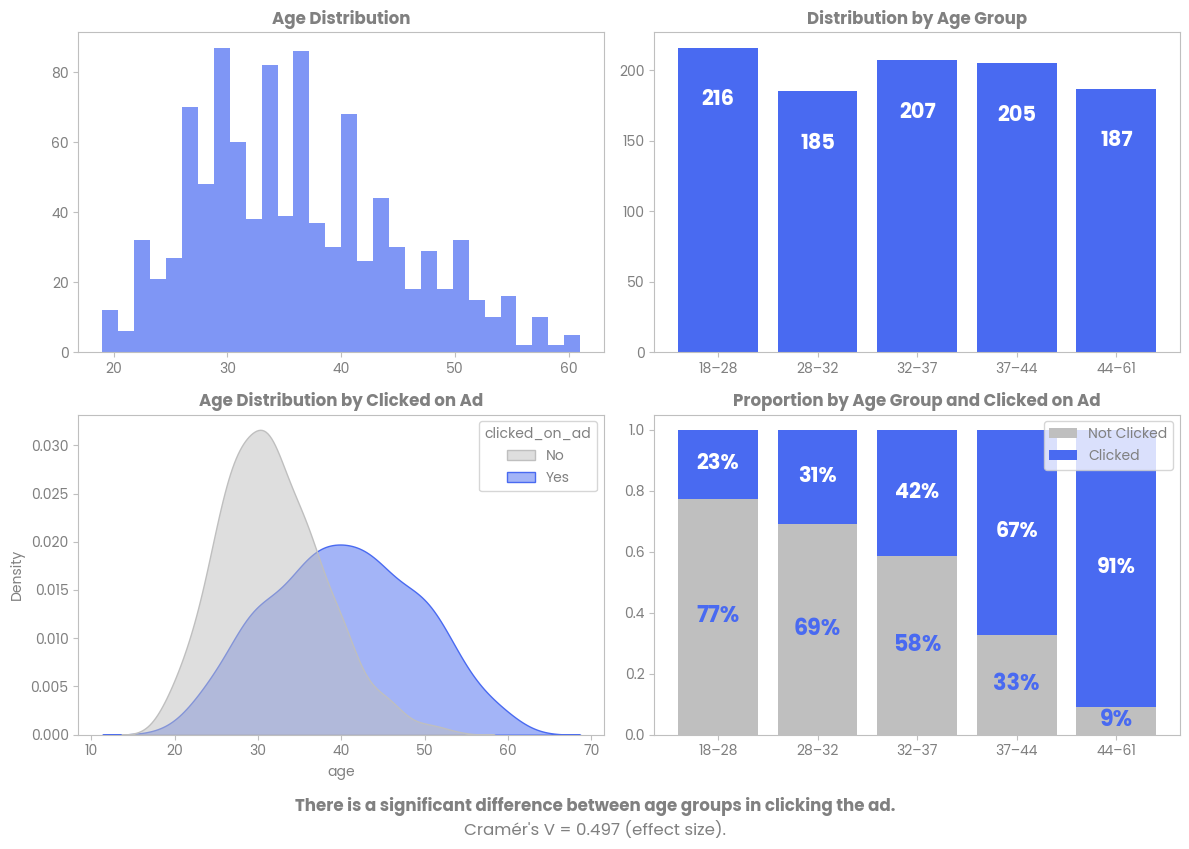

In [ ]:
contingency_age = pd.crosstab(df['age_group'], df['clicked_on_ad'])
chi2_age, p_age, dof_age, expected_age = chi2_contingency(contingency_age)

if p_age < 0.05:
    interpretation_age = "There is a significant difference between age groups in clicking the ad."
else:
    interpretation_age = "There is no significant difference between age groups in clicking the ad."

n = contingency_age.sum().sum()
cramers_v_age = np.sqrt(chi2_age / (n * (min(contingency_age.shape)-1)))
correlation_age = f"Cramér's V = {cramers_v_age:.3f} (effect size)."

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1])

# Histogram of Age
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df['age'], bins=30, alpha=0.7)
ax1.set_title('Age Distribution', fontweight='bold')

# Bar chart of Age Group Counts
ax2 = fig.add_subplot(gs[0, 1])
age_counts = df['age_group'].value_counts().sort_index()
bars = ax2.bar(age_counts.index, age_counts.values, width=0.8)
ax2.set_title('Distribution by Age Group', fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height - 45, int(height), ha='center', va='bottom', fontweight='bold', fontsize=15, color='white')

# KDE plot of Age by Clicked on Ad
ax3 = fig.add_subplot(gs[1, 0])
sns.kdeplot(data=df, x='age', hue='clicked_on_ad', ax=ax3, fill=True, alpha=0.5, palette={'No': '#BFBFBF', 'Yes': '#496af1'})
ax3.set_title('Age Distribution by Clicked on Ad', fontweight='bold')

# Proportion of clicks per Age Group
ax4 = fig.add_subplot(gs[1, 1])
age_clicked_counts = df.groupby(['age_group', 'clicked_on_ad']).size().unstack(fill_value=0)
age_clicked_props = age_clicked_counts.div(age_clicked_counts.sum(axis=1), axis=0)
bars1 = ax4.bar(age_clicked_props.index, age_clicked_props['No'], label='Not Clicked', width=0.8, color='#BFBFBF')
bars2 = ax4.bar(age_clicked_props.index, age_clicked_props['Yes'], bottom=age_clicked_props['No'], label='Clicked', width=0.8, color='#496af1')
ax4.set_title('Proportion by Age Group and Clicked on Ad', fontweight='bold')
ax4.legend()
for i, age in enumerate(age_clicked_props.index):
    ax4.text(i, age_clicked_props.loc[age, 'No']/2, f"{age_clicked_props.loc[age, 'No']:.0%}", ha='center', va='center', color='#496af1', fontweight='bold', fontsize=16)
    ax4.text(i, age_clicked_props.loc[age, 'No'] + age_clicked_props.loc[age, 'Yes']/2, f"{age_clicked_props.loc[age, 'Yes']:.0%}", ha='center', va='center', color='white', fontweight='bold', fontsize=15)

plt.figtext(0.5, -0.02, interpretation_age, wrap=True, ha='center', fontsize=12, fontweight='bold')
plt.figtext(0.5, -0.05, correlation_age, wrap=True, ha='center', fontsize=12)

plt.tight_layout()
plt.show()

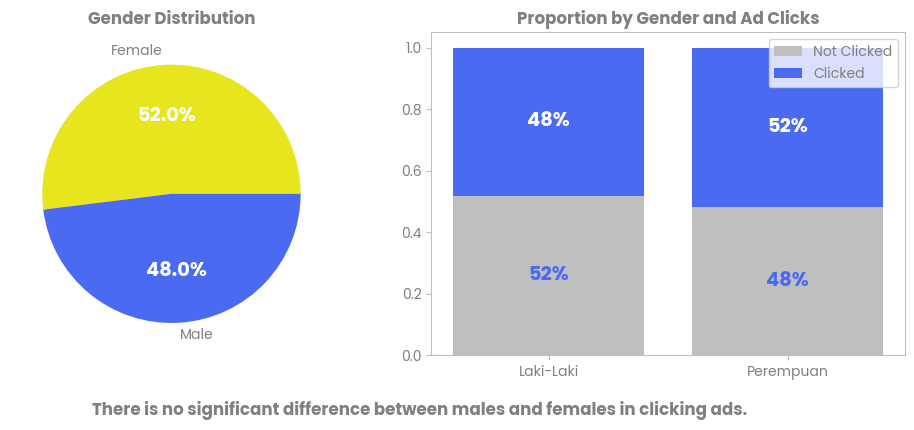

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Create contingency table and perform chi-square test
contingency_table = pd.crosstab(df['male'], df['clicked_on_ad'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Interpretation based on p-value
if p < 0.05:
    interpretation = "There is a significant difference between males and females in clicking ads."
else:
    interpretation = "There is no significant difference between males and females in clicking ads."

# Calculate ad click proportions by gender
ad_clicks = df.groupby('male')['clicked_on_ad'].value_counts(normalize=True).unstack().fillna(0)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Pie chart for gender distribution
gender_counts = df['male'].value_counts()
wedges, texts, autotexts = axes[0].pie(
    gender_counts.values,
    labels=['Female', 'Male'],
    autopct='%1.1f%%',
    colors=['#e6e51e', '#496af1']
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)
axes[0].set_title('Gender Distribution', fontweight='bold')

# Stacked bar chart for ad clicks by gender
bars1 = axes[1].bar(ad_clicks.index, ad_clicks['No'], label='Not Clicked', width=0.8, color='#BFBFBF')
bars2 = axes[1].bar(ad_clicks.index, ad_clicks['Yes'], bottom=ad_clicks['No'], label='Clicked', width=0.8, color='#496af1')

axes[1].set_title('Proportion by Gender and Ad Clicks', fontweight='bold')
axes[1].legend()

# Adding percentage labels on bars
for i, gender in enumerate(ad_clicks.index):
    axes[1].text(
        i,
        ad_clicks.loc[gender, 'No']/2,
        f"{ad_clicks.loc[gender, 'No']:.0%}",
        ha='center', va='center', color='#496af1', fontweight='bold', fontsize=14
    )
    axes[1].text(
        i,
        ad_clicks.loc[gender, 'No'] + ad_clicks.loc[gender, 'Yes']/2,
        f"{ad_clicks.loc[gender, 'Yes']:.0%}",
        ha='center', va='center', color='white', fontweight='bold', fontsize=14
    )

# Display chi-square interpretation below the plot
plt.figtext(0.5, -0.05, interpretation, wrap=True, ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

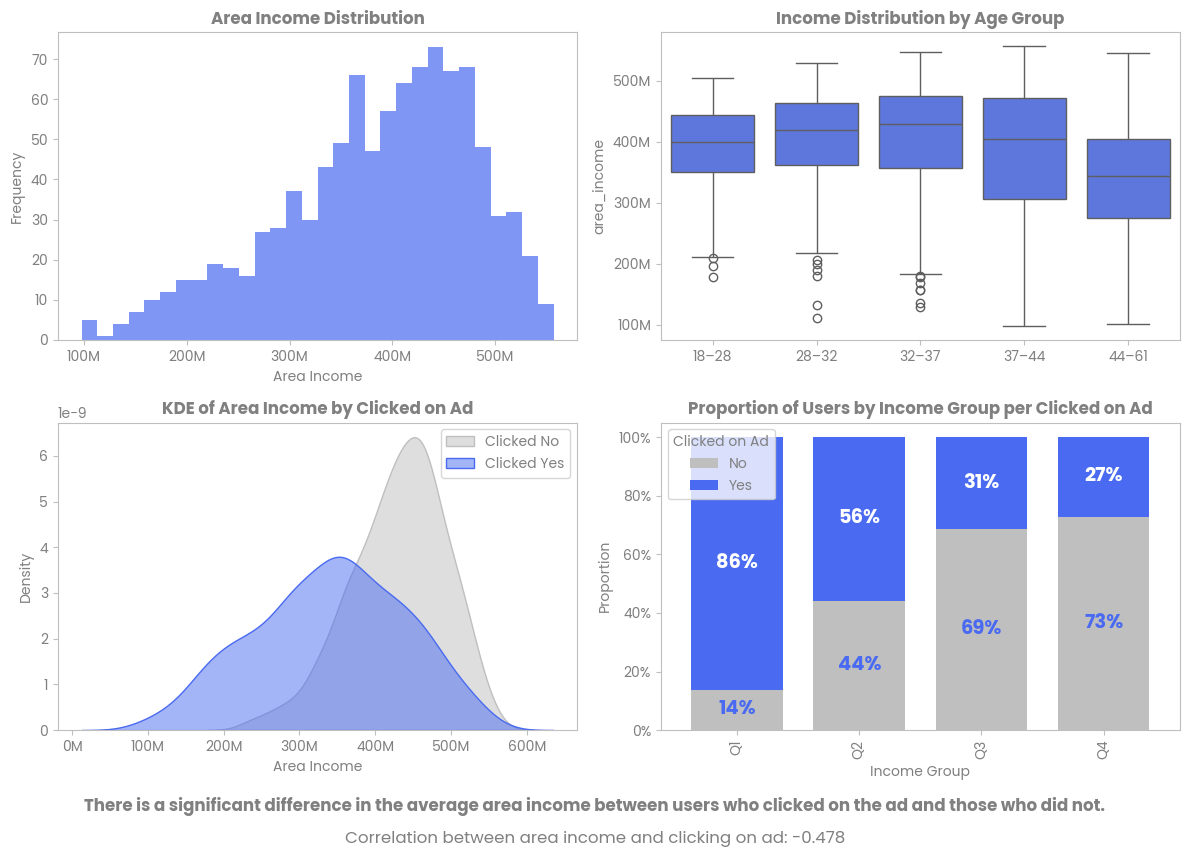

In [ ]:
# Map 'clicked_on_ad' column to numeric values for correlation calculation
df['clicked_on_ad_num'] = df['clicked_on_ad'].map({'No': 0, 'Yes': 1})

# Calculate correlation between area income and clicking on ad
corr_income_click = df[['area_income', 'clicked_on_ad_num']].corr().loc['area_income', 'clicked_on_ad_num']

# Separate area income by users who clicked and did not click
income_clicked = df[df['clicked_on_ad'] == 'Yes']['area_income'].dropna()
income_not_clicked = df[df['clicked_on_ad'] == 'No']['area_income'].dropna()

# Perform independent t-test
t_stat, p_val = ttest_ind(income_clicked, income_not_clicked, equal_var=False)

# Interpret the results
if p_val < 0.05:
    income_interpretation = "There is a significant difference in the average area income between users who clicked on the ad and those who did not."
else:
    income_interpretation = "There is no significant difference in the average area income between users who clicked on the ad and those who did not."

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histogram of area income
axes[0, 0].hist(df['area_income'].dropna(), bins=30, alpha=0.7)
axes[0, 0].set_title('Area Income Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Area Income')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].xaxis.set_major_formatter(formatter)

# Boxplot of area income by age group
sns.boxplot(data=df, x='age_group', y='area_income', ax=axes[0, 1])
axes[0, 1].set_title('Income Distribution by Age Group', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].set_xlabel('')
axes[0, 1].yaxis.set_major_formatter(formatter)

# KDE plot of area income by clicked on ad
pal = {'No': '#BFBFBF', 'Yes': '#496af1'}
for clicked_value in df['clicked_on_ad'].unique():
    subset = df[df['clicked_on_ad'] == clicked_value]['area_income'].dropna()
    sns.kdeplot(subset, ax=axes[1, 0], label=f'Clicked {clicked_value}', fill=True, alpha=0.5, color=pal[clicked_value])
axes[1, 0].set_title('KDE of Area Income by Clicked on Ad', fontweight='bold')
axes[1, 0].set_xlabel('Area Income')
axes[1, 0].set_ylabel('Density')
axes[1, 0].xaxis.set_major_formatter(formatter)
axes[1, 0].legend()

# Group area income into quartiles
df['income_group'] = pd.qcut(df['area_income'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Calculate proportion of users by income group per clicked on ad
income_click_counts = df.groupby(['income_group', 'clicked_on_ad']).size().unstack(fill_value=0)
income_click_counts_pct = income_click_counts.div(income_click_counts.sum(axis=1), axis=0)

# Stacked bar plot of proportions
income_click_counts_pct.plot(kind='bar', stacked=True, ax=axes[1, 1], color=pal, width=0.75)
axes[1, 1].set_title('Proportion of Users by Income Group per Clicked on Ad', fontweight='bold')
axes[1, 1].set_xlabel('Income Group')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1, 1].legend(title='Clicked on Ad')

# Add percentage text labels to stacked bars
for i, income in enumerate(income_click_counts_pct.index):
    no_val = income_click_counts_pct.loc[income, 'No']
    yes_val = income_click_counts_pct.loc[income, 'Yes']

    axes[1, 1].text(i, no_val/2, f"{no_val:.0%}", ha='center', va='center', color='#496af1', fontweight='bold', fontsize=14)
    axes[1, 1].text(i, no_val + yes_val/2, f"{yes_val:.0%}", ha='center', va='center', color='white', fontweight='bold', fontsize=14)

# Add interpretation and correlation text below the figure
plt.figtext(0.5, -0.02, income_interpretation, wrap=True, ha='center', fontsize=12, fontweight='bold')
plt.figtext(0.5, -0.06, f"Correlation between area income and clicking on ad: {corr_income_click:.3f}", wrap=True, ha='center', fontsize=12)

plt.tight_layout()
plt.show()

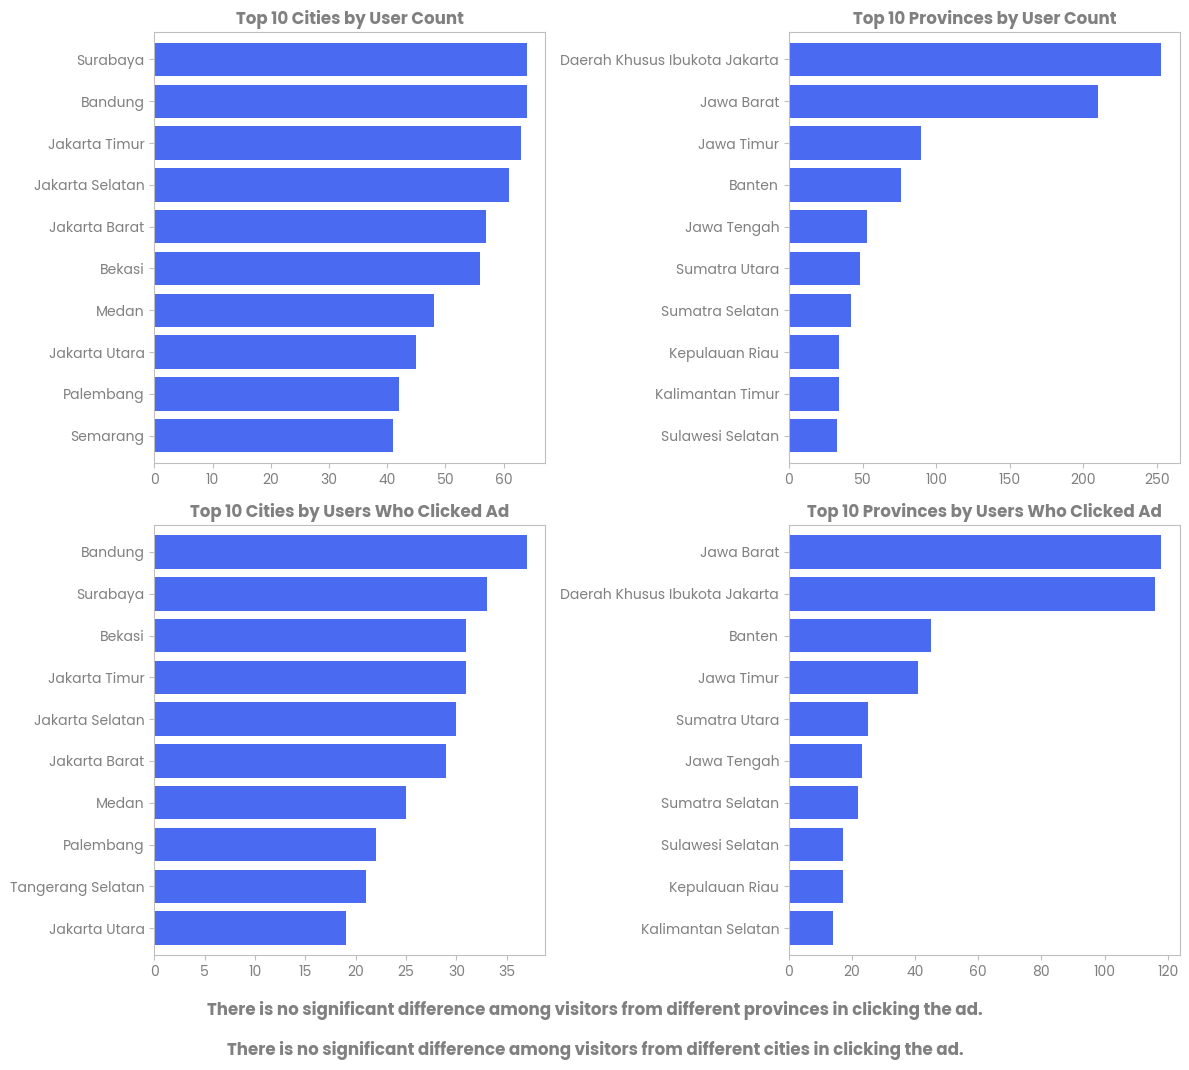

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Chi-square test for province
contingency_table = pd.crosstab(df['province'], df['clicked_on_ad'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.05:
    province_interpretation = "There is a significant difference among visitors from different provinces in clicking the ad."
else:
    province_interpretation = "There is no significant difference among visitors from different provinces in clicking the ad."

# Chi-square test for city
contingency_table = pd.crosstab(df['city'], df['clicked_on_ad'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.05:
    city_interpretation = "There is a significant difference among visitors from different cities in clicking the ad."
else:
    city_interpretation = "There is no significant difference among visitors from different cities in clicking the ad."

# Top 10 cities and provinces overall and for those who clicked the ad
top_cities = df['city'].value_counts().head(10)
top_provinces = df['province'].value_counts().head(10)

clicked_df = df[df['clicked_on_ad'] == 'Yes']
top_cities_clicked = clicked_df['city'].value_counts().head(10)
top_provinces_clicked = clicked_df['province'].value_counts().head(10)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

top_cities.iloc[::-1].plot(kind='barh', ax=axes[0,0], width=0.8)
axes[0,0].set_title('Top 10 Cities by User Count', fontweight='bold')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('')

top_provinces.iloc[::-1].plot(kind='barh', ax=axes[0,1], width=0.8)
axes[0,1].set_title('Top 10 Provinces by User Count', fontweight='bold')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

top_cities_clicked.iloc[::-1].plot(kind='barh', ax=axes[1,0], width=0.8)
axes[1,0].set_title('Top 10 Cities by Users Who Clicked Ad', fontweight='bold')
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('')

top_provinces_clicked.iloc[::-1].plot(kind='barh', ax=axes[1,1], width=0.8)
axes[1,1].set_title('Top 10 Provinces by Users Who Clicked Ad', fontweight='bold')
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')

plt.figtext(0.5, -0.02, province_interpretation, wrap=True, ha='center', fontsize=12, fontweight='bold')
plt.figtext(0.5, -0.06, city_interpretation, wrap=True, ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

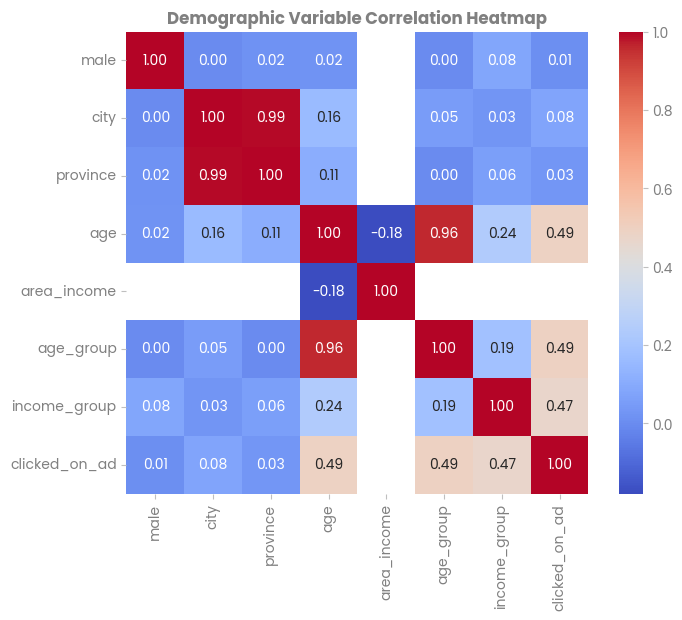

In [ ]:
# Define columns
demo_cols = ['male', 'city', 'province', 'age', 'area_income', 'age_group', 'income_group', 'clicked_on_ad']
demo_num = ['age', 'area_income']  # numeric columns
demo_cat = ['male', 'city', 'province', 'age_group', 'income_group', 'clicked_on_ad']  # categorical columns

# Initialize correlation matrix
corr_demo = pd.DataFrame(np.zeros((len(demo_cols), len(demo_cols))), index=demo_cols, columns=demo_cols)

for i in demo_cols:
    for j in demo_cols:
        if i == j:
            corr_demo.loc[i, j] = 1.0

        # numeric vs numeric (Pearson correlation)
        elif (i in demo_num) and (j in demo_num):
            corr_demo.loc[i, j] = df[i].corr(df[j], method='pearson')

        # categorical vs categorical (Cramér's V)
        elif (i in demo_cat) and (j in demo_cat):
            confusion_matrix = pd.crosstab(df[i], df[j])
            chi2 = chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            corr_demo.loc[i, j] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

        # numeric vs categorical (Correlation Ratio / η)
        else:
            if i in demo_num:  # i numeric, j categorical
                values = df[i].values
                fcat, _ = pd.factorize(df[j])
            else:              # i categorical, j numeric
                values = df[j].values
                fcat, _ = pd.factorize(df[i])

            cat_num = np.max(fcat) + 1
            y_avg_array = np.zeros(cat_num)
            n_array = np.zeros(cat_num)

            for k in range(cat_num):
                cat_values = values[np.argwhere(fcat == k).flatten()]
                n_array[k] = len(cat_values)
                y_avg_array[k] = np.mean(cat_values) if len(cat_values) > 0 else 0

            y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
            numerator = np.sum(n_array * (y_avg_array - y_total_avg)**2)
            denominator = np.sum((values - y_total_avg)**2)
            eta = np.sqrt(numerator / denominator) if denominator != 0 else 0.0
            corr_demo.loc[i, j] = eta

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_demo, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Demographic Variable Correlation Heatmap", fontweight='bold')
plt.show()

## **3.3. User Behavior Analysis**

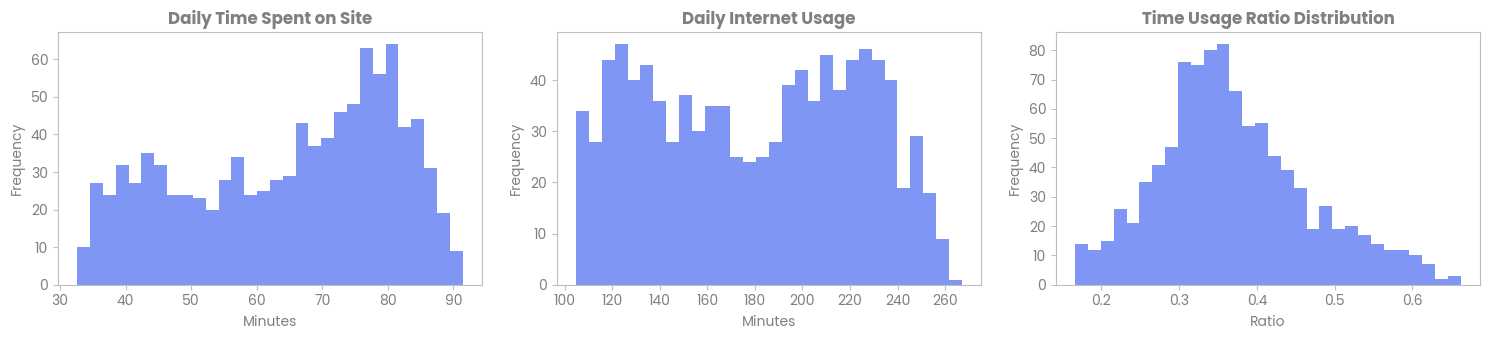

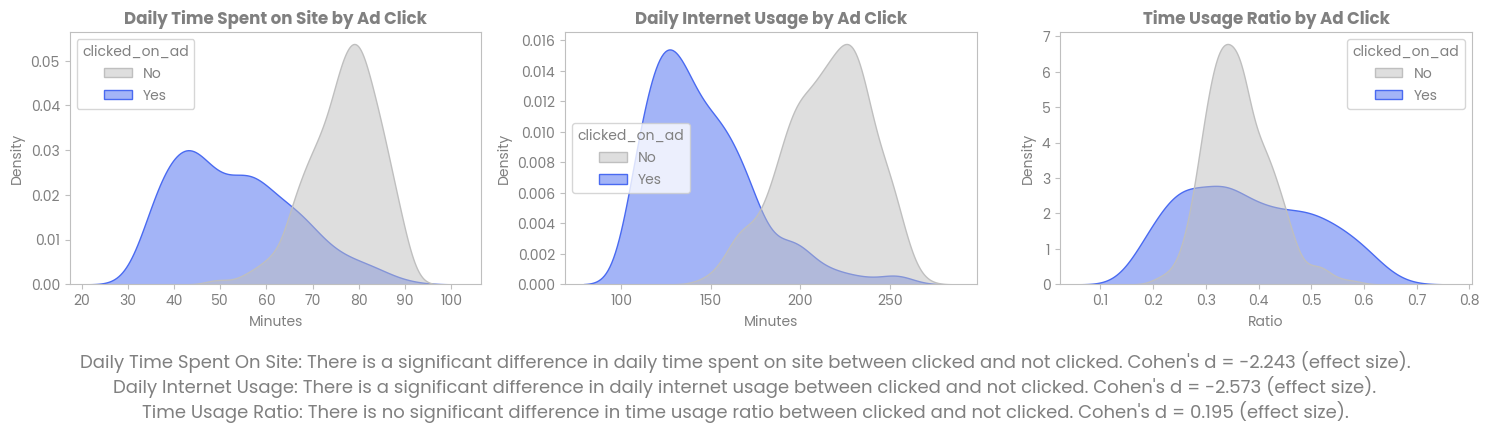

In [ ]:
# Histogram plots
plt.figure(figsize=(15, 3.5))

# Daily Time Spent on Site
plt.subplot(1, 3, 1)
plt.hist(df['daily_time_spent_on_site'].dropna(), bins=30, alpha=0.7)
plt.title('Daily Time Spent on Site', fontweight='bold')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

# Daily Internet Usage
plt.subplot(1, 3, 2)
plt.hist(df['daily_internet_usage'].dropna(), bins=30, alpha=0.7)
plt.title('Daily Internet Usage', fontweight='bold')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

# Time Usage Ratio
plt.subplot(1, 3, 3)
plt.hist(df['time_usage_ratio'].dropna(), bins=30, alpha=0.7)
plt.title('Time Usage Ratio Distribution', fontweight='bold')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.tight_layout()

# Uji statistik (Mann-Whitney + Cohen's d)
results = []

for var in ['daily_time_spent_on_site', 'daily_internet_usage', 'time_usage_ratio']:
    group_yes = df[df['clicked_on_ad'] == 'Yes'][var].dropna()
    group_no = df[df['clicked_on_ad'] == 'No'][var].dropna()

    # Mann-Whitney U Test
    stat, p = mannwhitneyu(group_yes, group_no, alternative='two-sided')

    if p < 0.05:
        interpretation = f"There is a significant difference in {var.replace('_',' ')} between clicked and not clicked."
    else:
        interpretation = f"There is no significant difference in {var.replace('_',' ')} between clicked and not clicked."

    # Cohen's d
    mean_diff = group_yes.mean() - group_no.mean()
    pooled_std = np.sqrt(((group_yes.std() ** 2) + (group_no.std() ** 2)) / 2)
    cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

    effect_size = f"Cohen's d = {cohens_d:.3f} (effect size)."

    results.append(f"{var.replace('_',' ').title()}: {interpretation} {effect_size}")

# Gabungkan semua hasil
text_output = "\n".join(results)

plt.show()

# KDE plots
plt.figure(figsize=(15, 3.5))

# Daily Time Spent on Site KDE
plt.subplot(1, 3, 1)
sns.kdeplot(data=df, x='daily_time_spent_on_site', hue='clicked_on_ad',
            common_norm=False, fill=True, alpha=0.5,
            palette={'No': '#BFBFBF', 'Yes': '#496af1'})
plt.title('Daily Time Spent on Site by Ad Click', fontweight='bold')
plt.xlabel('Minutes')
plt.ylabel('Density')

# Daily Internet Usage KDE
plt.subplot(1, 3, 2)
sns.kdeplot(data=df, x='daily_internet_usage', hue='clicked_on_ad',
            common_norm=False, fill=True, alpha=0.5,
            palette={'No': '#BFBFBF', 'Yes': '#496af1'})
plt.title('Daily Internet Usage by Ad Click', fontweight='bold')
plt.xlabel('Minutes')
plt.ylabel('Density')

# Time Usage Ratio KDE
plt.subplot(1, 3, 3)
sns.kdeplot(data=df, x='time_usage_ratio', hue='clicked_on_ad',
            common_norm=False, fill=True, alpha=0.5,
            palette={'No': '#BFBFBF', 'Yes': '#496af1'})
plt.title('Time Usage Ratio by Ad Click', fontweight='bold')
plt.xlabel('Ratio')
plt.ylabel('Density')

plt.tight_layout()

# Tambahkan hasil uji statistik yang sama ke bawah grafik KDE
plt.figtext(0.5, -0.2, text_output, wrap=True, ha='center', fontsize=13)

plt.show()

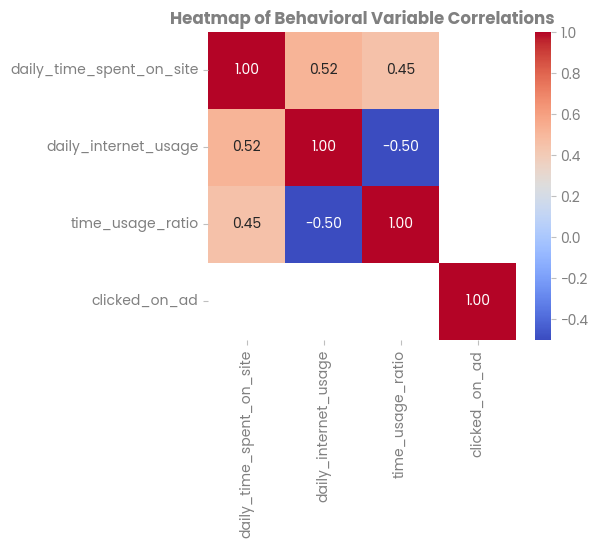

In [ ]:
temp_cols = ['daily_time_spent_on_site', 'daily_internet_usage', 'time_usage_ratio', 'clicked_on_ad']
temp_num = ['daily_time_spent_on_site', 'daily_internet_usage', 'time_usage_ratio']
temp_cat = ['clicked_on_ad']
corr_demo = pd.DataFrame(np.zeros((len(temp_cols), len(temp_cols))), index=temp_cols, columns=temp_cols)

for i in temp_cols:
    for j in temp_cols:
        if i == j:
            corr_demo.loc[i, j] = 1.0

        # numeric vs numeric (Pearson correlation)
        elif (i in temp_num) and (j in temp_num):
            corr_demo.loc[i, j] = df[i].corr(df[j], method='pearson')

        # categorical vs categorical (Cramér's V)
        elif (i in temp_cat) and (j in temp_cat):
            confusion_matrix = pd.crosstab(df[i], df[j])
            chi2 = chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            corr_demo.loc[i, j] = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

        # numeric vs categorical (Correlation Ratio / η)
        else:
            if i in temp_num:  # i is numeric, j is categorical
                values = df[i].values
                fcat, _ = pd.factorize(df[j])
            else:              # i is categorical, j is numeric
                values = df[j].values
                fcat, _ = pd.factorize(df[i])

            cat_num = np.max(fcat) + 1
            y_avg_array = np.zeros(cat_num)
            n_array = np.zeros(cat_num)

            for k in range(cat_num):
                cat_values = values[np.argwhere(fcat == k).flatten()]
                n_array[k] = len(cat_values)
                y_avg_array[k] = np.mean(cat_values) if len(cat_values) > 0 else 0

            y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
            numerator = np.sum(n_array * (y_avg_array - y_total_avg)**2)
            denominator = np.sum((values - y_total_avg)**2)
            eta = np.sqrt(numerator / denominator) if denominator != 0 else 0.0
            corr_demo.loc[i, j] = eta

plt.figure(figsize=(5,4))
sns.heatmap(corr_demo, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Heatmap of Behavioral Variable Correlations", fontweight='bold')
plt.show()

## **3.4. Temporal Analysis**

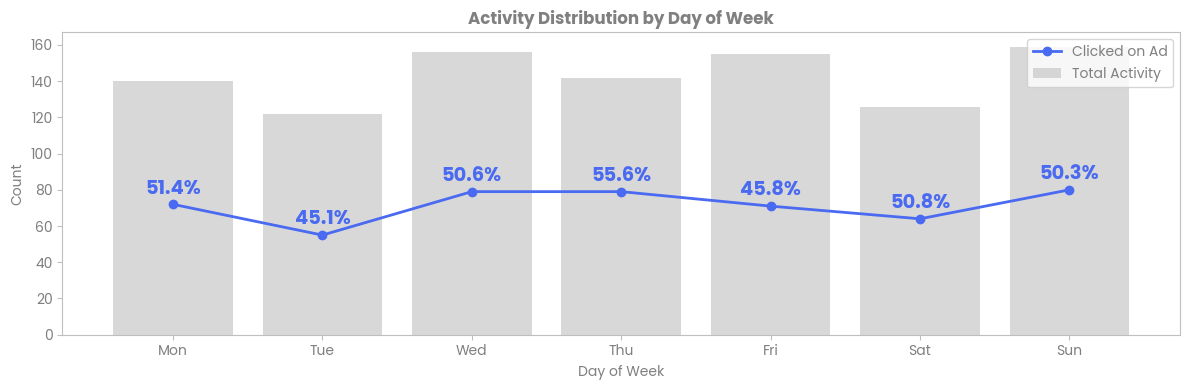

In [ ]:
day_counts = df['day_of_week'].value_counts().sort_index()
clicked_counts = df[df['clicked_on_ad'] == 'Yes']['day_of_week'].value_counts().sort_index()
clicked_counts = clicked_counts.reindex(day_counts.index, fill_value=0)

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(12, 4))
plt.bar(range(len(day_counts)), day_counts.values, alpha=0.6, label='Total Activity', color='#BFBFBF')
plt.plot(range(len(clicked_counts)), clicked_counts.values, marker='o', linewidth=2, label='Clicked on Ad')
percentages = (clicked_counts / day_counts * 100).round(1)

for i, (x, y, pct) in enumerate(zip(range(len(clicked_counts)), clicked_counts.values, percentages)):
    plt.text(x, y + max(day_counts)*0.02, f'{pct}%', ha='center', va='bottom', fontsize=14, fontweight='bold', color='#496af1')

plt.title('Activity Distribution by Day of Week', fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(range(len(days)), days)

plt.legend()
plt.tight_layout()
plt.show()

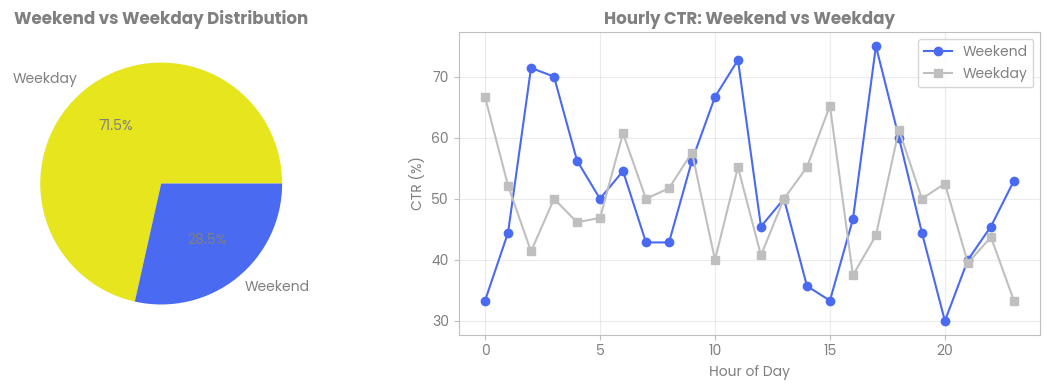

In [ ]:
plt.figure(figsize=(12, 4))

# Pie chart: Weekend vs Weekday
plt.subplot(1, 2, 1)
weekend_counts = df['is_weekend'].value_counts()
labels = ['Weekday', 'Weekend']
plt.pie(weekend_counts.values, labels=labels, autopct='%1.1f%%', colors=['#e6e51e', '#496af1'])
plt.title('Weekend vs Weekday Distribution', fontweight='bold')

# Hourly CTR: Weekend vs Weekday
plt.subplot(1, 2, 2)
weekend_ctr = (df[df['is_weekend'] == 1].groupby('hour')['clicked_on_ad_num'] .mean() * 100)
weekday_ctr = (df[df['is_weekend'] == 0].groupby('hour')['clicked_on_ad_num'].mean() * 100)

plt.plot(weekend_ctr.index, weekend_ctr.values, marker='o', label='Weekend')
plt.plot(weekday_ctr.index, weekday_ctr.values, marker='s', label='Weekday')
plt.title('Hourly CTR: Weekend vs Weekday', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('CTR (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

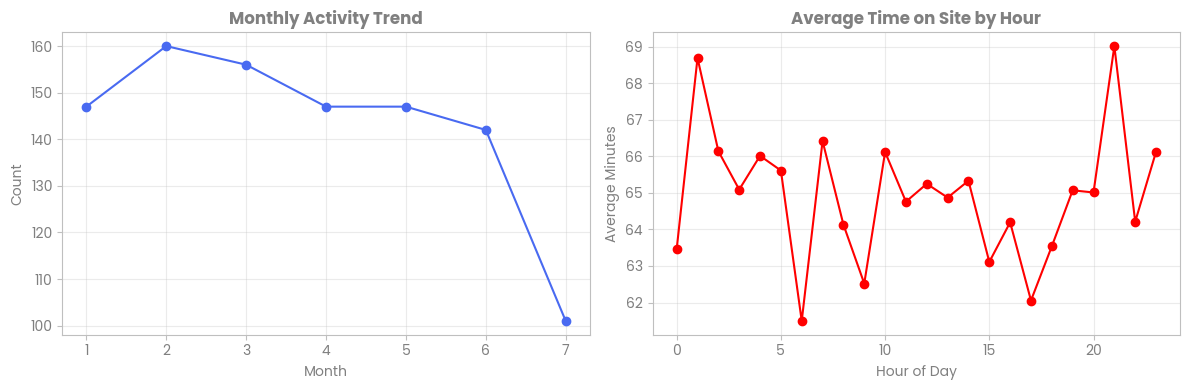

In [ ]:
plt.figure(figsize=(12, 4))

# Monthly trend
plt.subplot(1, 2, 1)
df['month'] = df['timestamp'].dt.month
monthly_counts = df['month'].value_counts().sort_index()
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title('Monthly Activity Trend', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# Time usage by hour
plt.subplot(1, 2, 2)
hourly_usage = df.groupby('hour')['daily_time_spent_on_site'].mean()
plt.plot(hourly_usage.index, hourly_usage.values, marker='o', color='red')
plt.title('Average Time on Site by Hour', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average Minutes')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("Temporal Insights:")
peak_hour = df['hour'].value_counts().idxmax()
print(f"Peak Activity Hour: {peak_hour}:00")
peak_day = df['day_of_week'].value_counts().idxmax()
days_mapping = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
print(f"Peak Activity Day: {days_mapping[peak_day]}")

Temporal Insights:
Peak Activity Hour: 7:00
Peak Activity Day: Sunday


#### **Summary of Temporal Analysis**

The data reveals variations in CTR patterns across different temporal variables. However, certain time segments, particularly those with limited hourly sample sizes (ranging from 6 to 17 samples), do not provide sufficient statistical reliability. Due to the inadequate sample size, observed CTR fluctuations during these time windows may be attributed to random noise rather than meaningful trends. Consequently, no actionable recommendations can be drawn from this analysis at this stage.

## **3.5. Category Analysis**

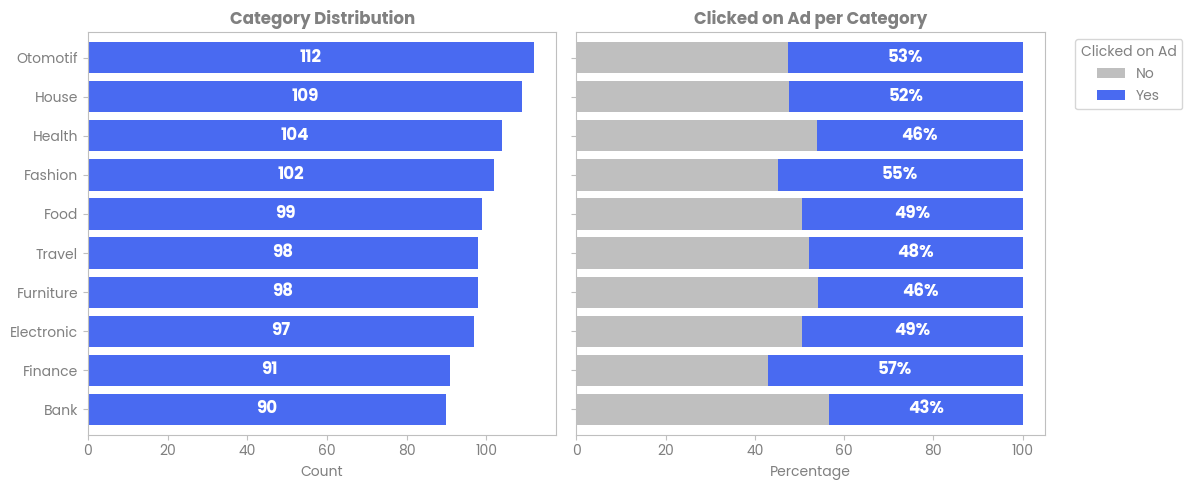

In [ ]:
category_counts = df['category'].value_counts().sort_values(ascending=True)
stacked_data = (df.groupby(['category', 'clicked_on_ad']).size().unstack(fill_value=0))

stacked_percent = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100
stacked_percent = stacked_percent.loc[category_counts.index]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].barh(category_counts.index, category_counts.values)
axes[0].set_title("Category Distribution", fontweight="bold")
axes[0].set_xlabel("Count")

for i, (count, category) in enumerate(zip(category_counts.values, category_counts.index)):
    axes[0].text(count/2, i, str(count), ha="center", va="center", color="white", fontweight="bold", fontsize=12)

stacked_percent.plot(kind="barh",  stacked=True, ax=axes[1], width=0.8, color={"No": "#BFBFBF", "Yes": "#496af1"})
axes[1].set_title("Clicked on Ad per Category", fontweight="bold")
axes[1].set_xlabel("Percentage")
axes[1].legend(title="Clicked on Ad", bbox_to_anchor=(1.05, 1), loc="upper left")

for i, category in enumerate(stacked_percent.index):
    if "Yes" in stacked_percent.columns:
        yes_value = stacked_percent.loc[category, "Yes"]
        no_value = stacked_percent.loc[category, "No"] if "No" in stacked_percent.columns else 0
        if yes_value > 0:
            axes[1].text(no_value + yes_value/2, i, f"{yes_value:.0f}%",  ha="center", va="center", color="white", fontweight="bold", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print("Category Statistics:")
print(df['category'].value_counts())

Category Statistics:
category
Otomotif      112
House         109
Health        104
Fashion       102
Food           99
Furniture      98
Travel         98
Electronic     97
Finance        91
Bank           90
Name: count, dtype: int64


#### **Summary of Category-Based Analysis**

The data presents CTR distribution across various content categories. While some categories show relatively higher sample sizes, such as Automotive (112), House (109), and Health (104), others fall closer to the lower threshold, with sample counts ranging from 90 to 99. Although the overall category-level sample sizes are moderately sufficient, the limited volume in certain categories may constrain the statistical reliability of deeper insights. As a result, any observed CTR differences across categories should be interpreted with caution, and further data collection is recommended before drawing actionable conclusions.

## **3.6. Target Variable Analysis**

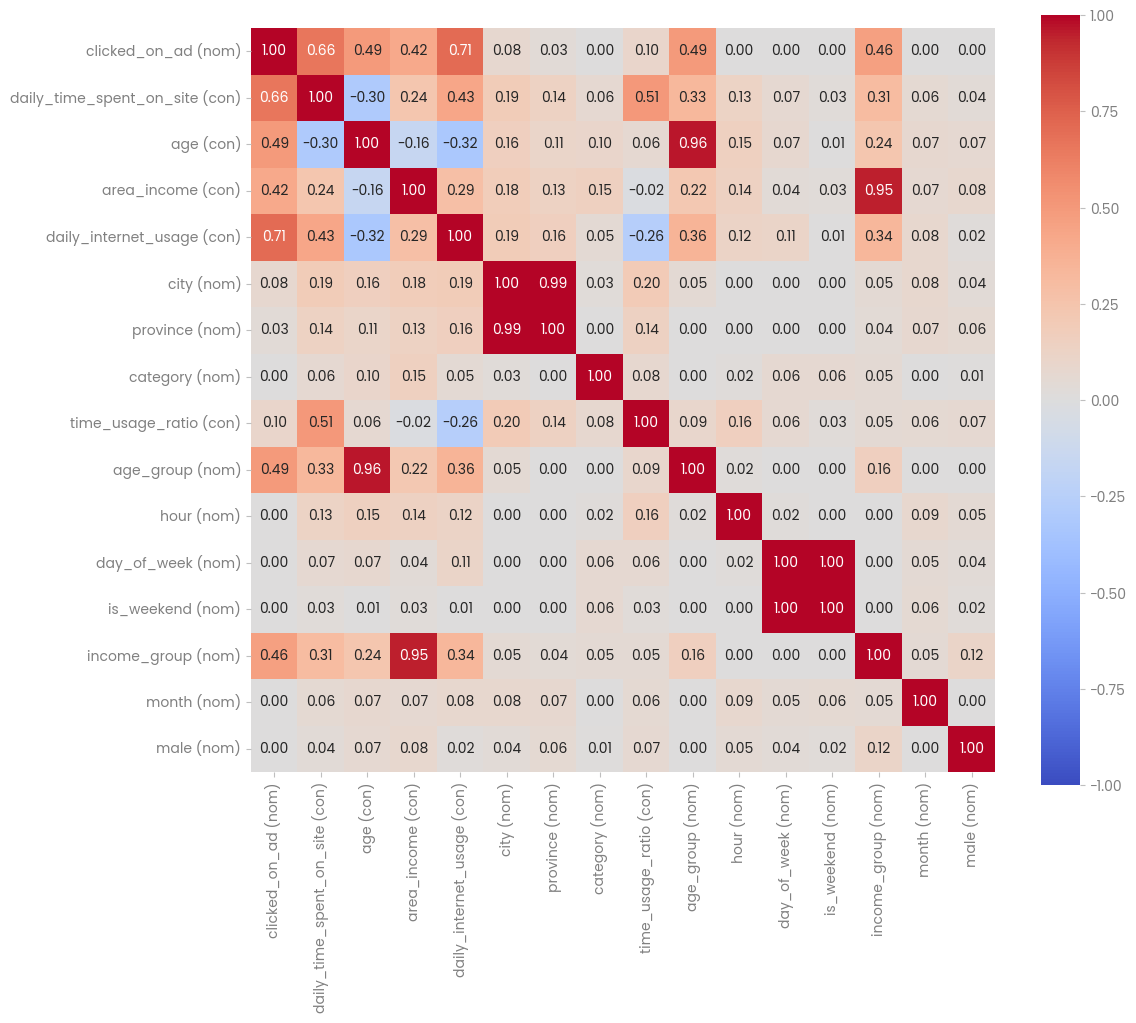

In [ ]:
df_corr = df[['clicked_on_ad', 'daily_time_spent_on_site', 'age', 'area_income', 'daily_internet_usage', 'city', 'province', 'category', 'time_usage_ratio', 'age_group', 'hour', 'day_of_week', 'is_weekend', 'income_group', 'month', 'male']]
nom_cols = ['clicked_on_ad', 'city', 'province', 'category', 'age_group', 'hour', 'day_of_week', 'is_weekend', 'income_group', 'month', 'male']

for col in nom_cols:
    df_corr[col] = df_corr[col].astype(str)

assoc = associations(df_corr, nominal_columns=nom_cols, cmap='coolwarm', mark_columns=True, plot=True, figsize=(12, 10))

In [ ]:
print("Ad Click Statistics:")
overall_click_rate = (df['clicked_on_ad']=='Yes').mean() * 100
print(f"Overall Click Rate: {overall_click_rate:.2f}%")

print("\nClick Rate by Demographics:")
age_click_rate = df.groupby('age_group')['clicked_on_ad'].apply(lambda x: (x=='Yes').mean() * 100)
print("By Age Group:")
for age, rate in age_click_rate.items():
    print(f"  {age}: {rate:.2f}%")

gender_click_rate = df.groupby('male')['clicked_on_ad'].apply(lambda x: (x=='Yes').mean() * 100)
print("By Gender:")
for gender, rate in gender_click_rate.items():
    print(f"  {gender}: {rate:.2f}%")

category_click_rate = df.groupby('category')['clicked_on_ad'].apply(lambda x: (x=='Yes').mean() * 100)
print("By Category:")
for category, rate in category_click_rate.items():
    print(f"  {category}: {rate:.2f}%")

Ad Click Statistics:
Overall Click Rate: 50.00%

Click Rate by Demographics:
By Age Group:
  18–28: 22.69%
  28–32: 30.81%
  32–37: 41.55%
  37–44: 67.32%
  44–61: 90.91%
By Gender:
  Laki-Laki: 48.23%
  Perempuan: 51.74%
By Category:
  Bank: 43.33%
  Electronic: 49.48%
  Fashion: 54.90%
  Finance: 57.14%
  Food: 49.49%
  Furniture: 45.92%
  Health: 46.15%
  House: 52.29%
  Otomotif: 52.68%
  Travel: 47.96%


## **3.7. Multivariate Analysis**

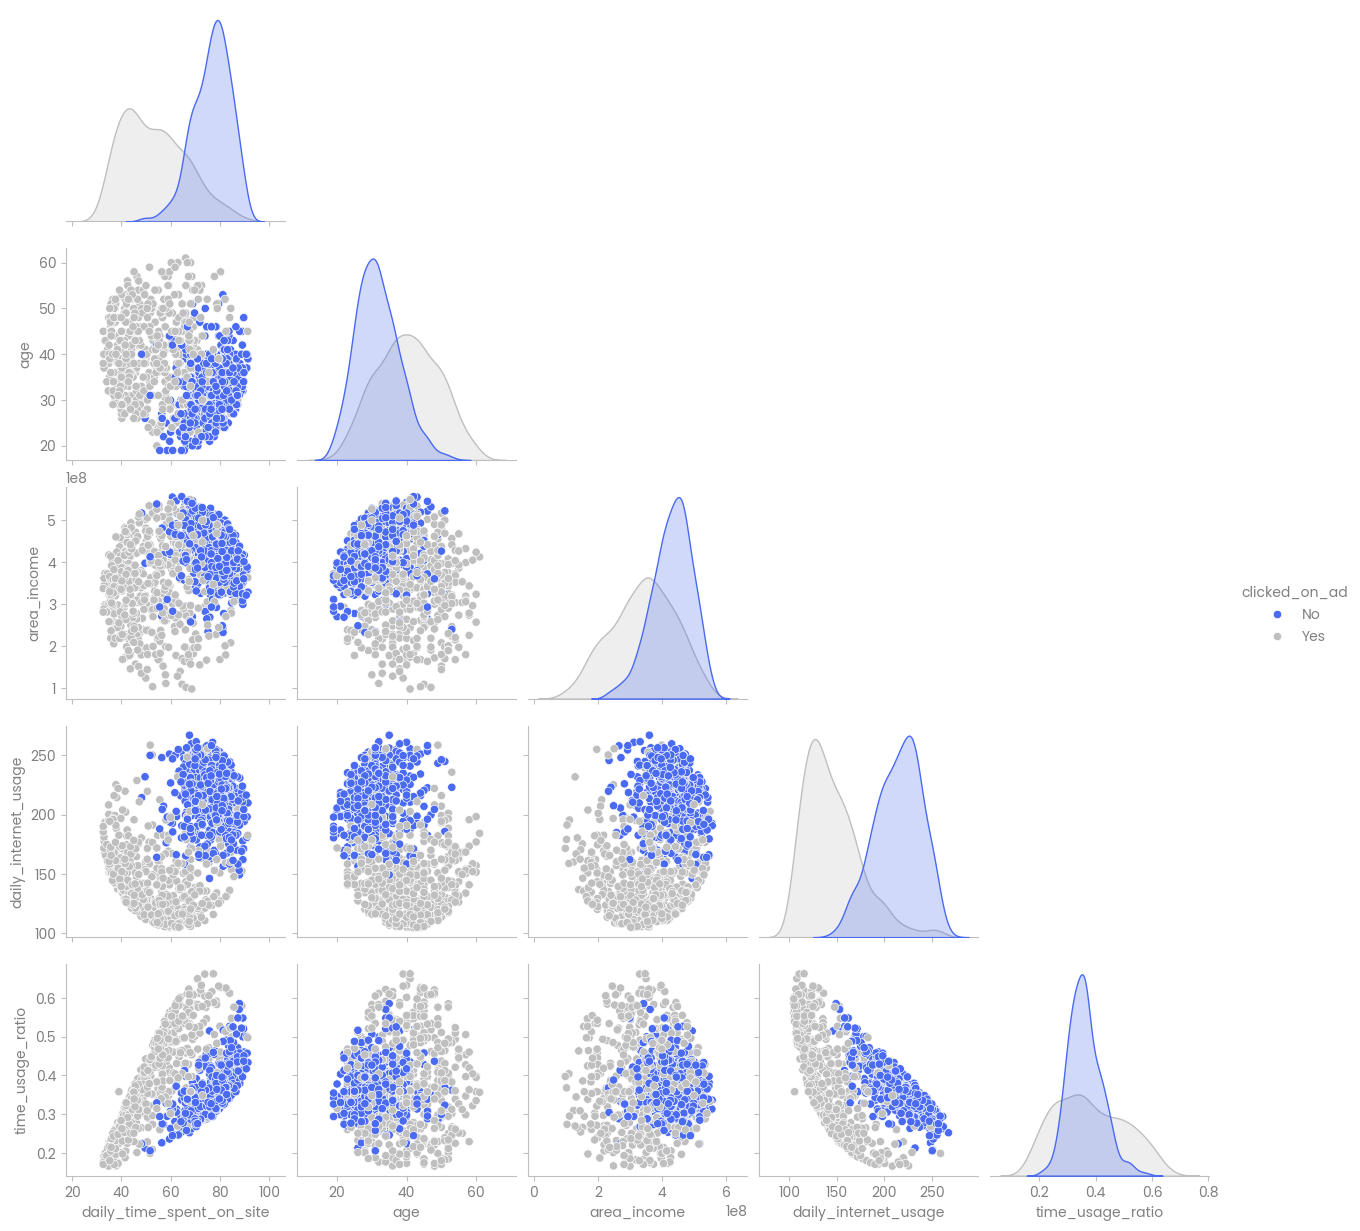

In [ ]:
numeric_cols = ["daily_time_spent_on_site", "age", "area_income", "daily_internet_usage", "time_usage_ratio"]
sns.pairplot(df[numeric_cols + ["clicked_on_ad"]], hue="clicked_on_ad", corner=True)
plt.show()

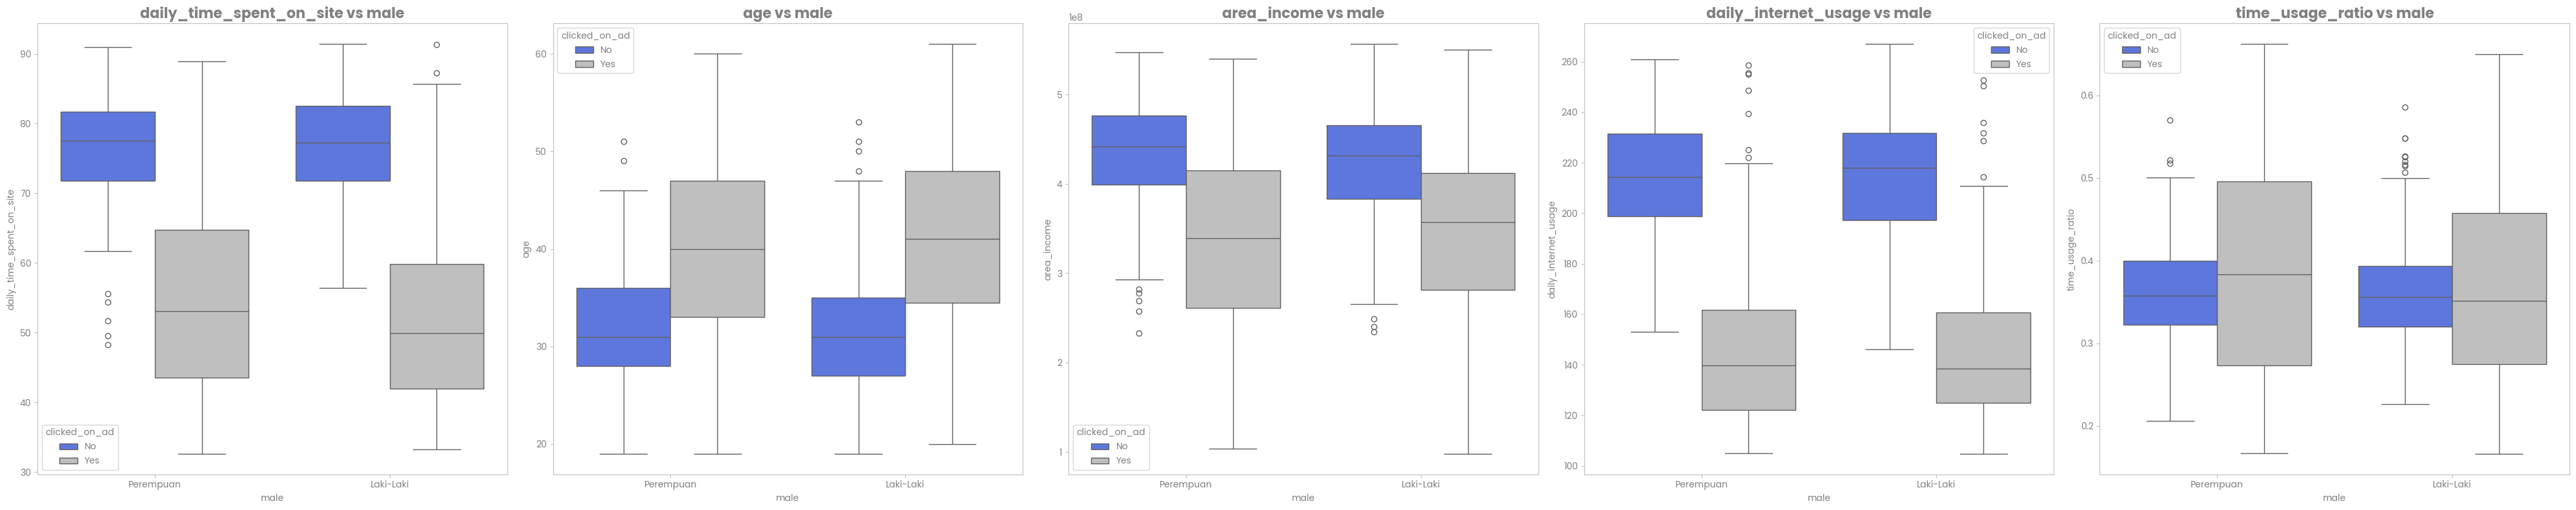

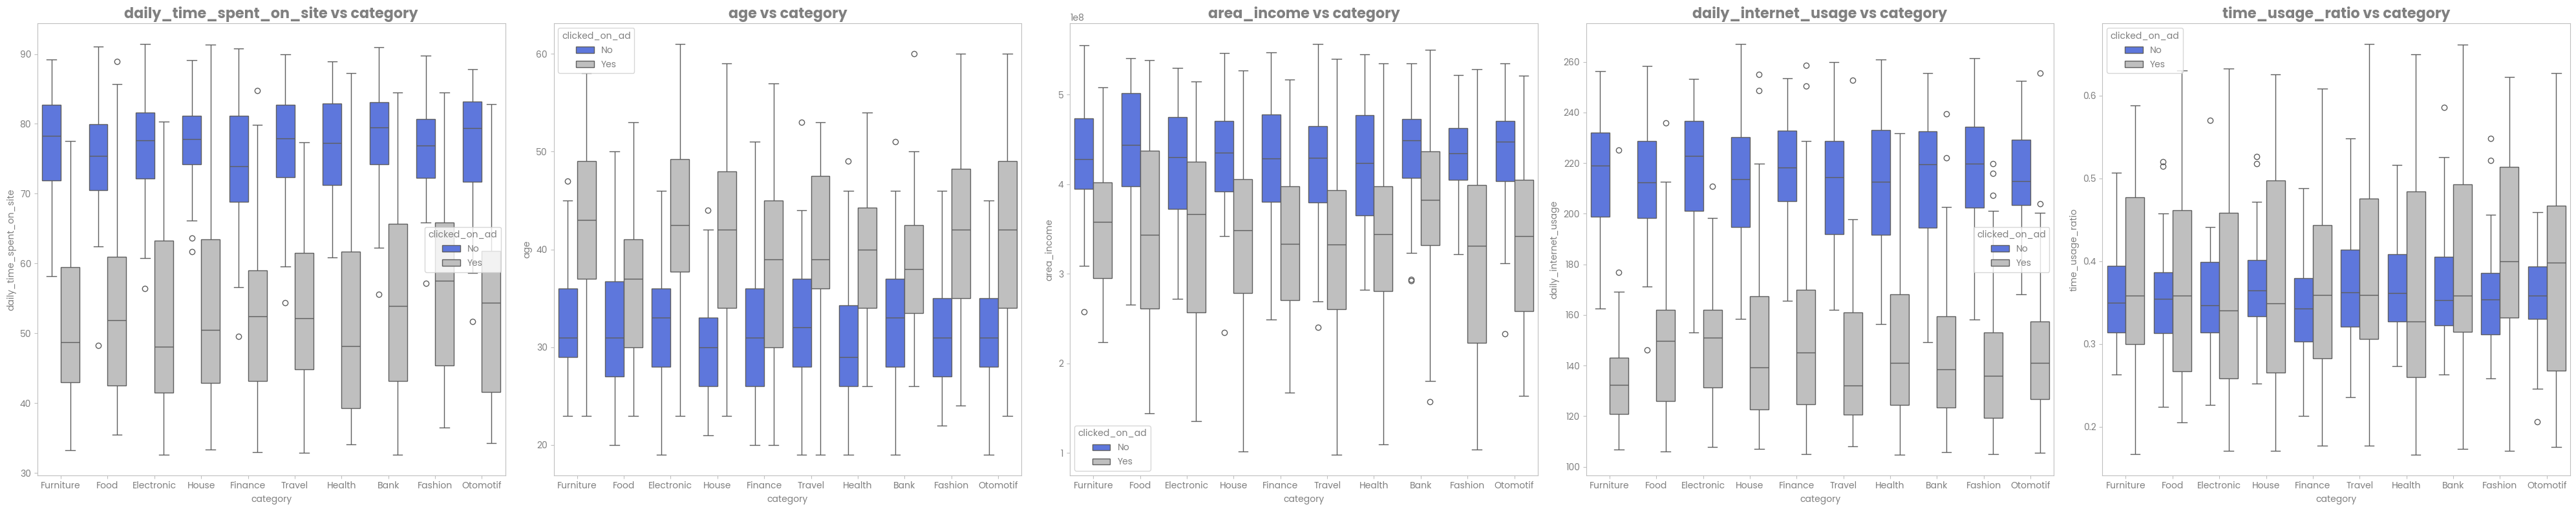

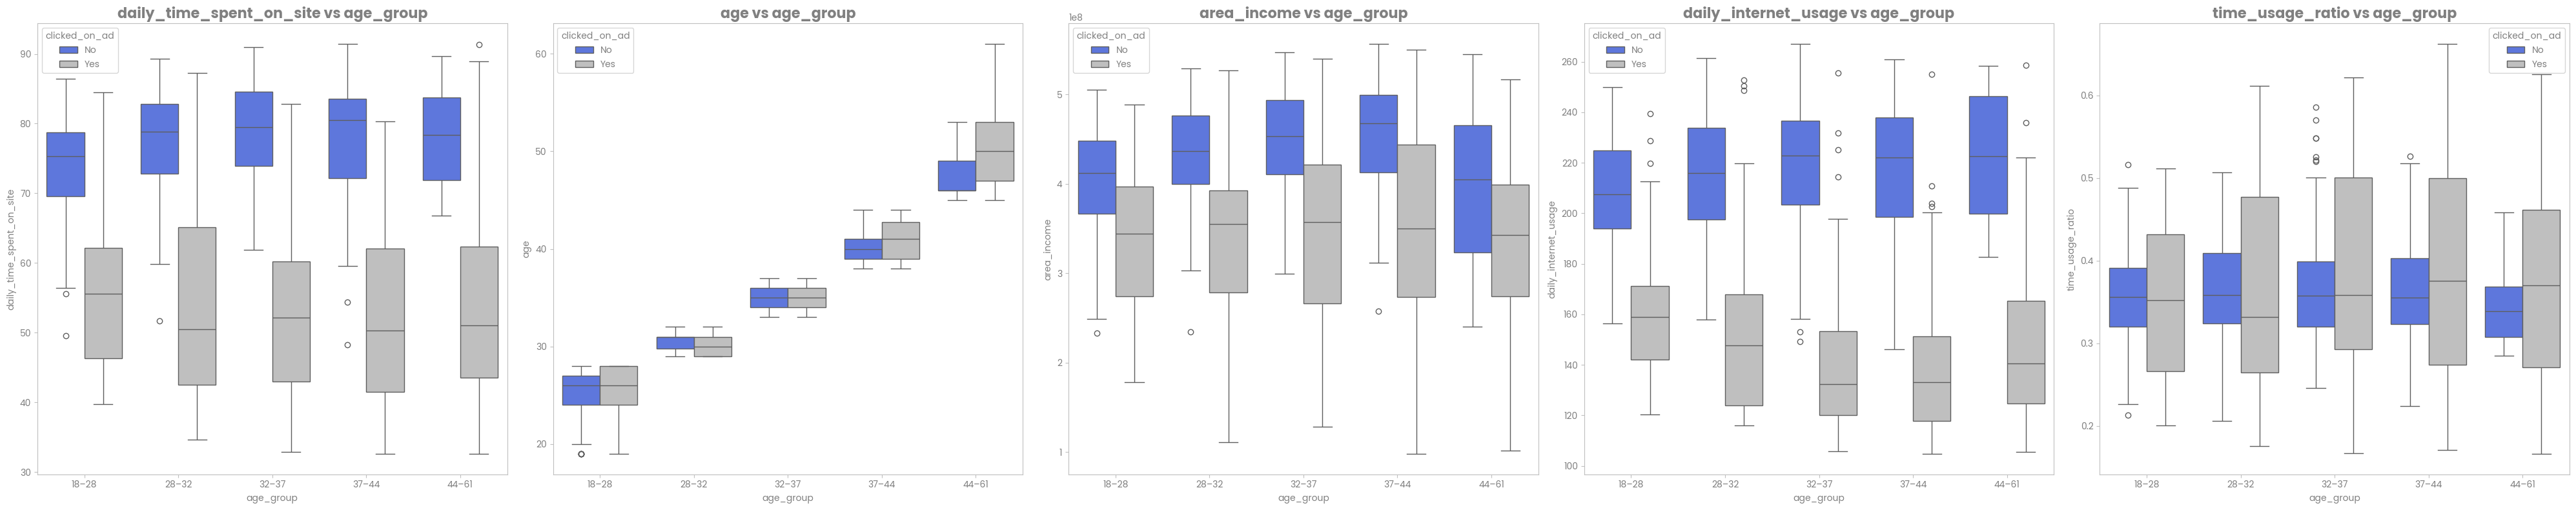

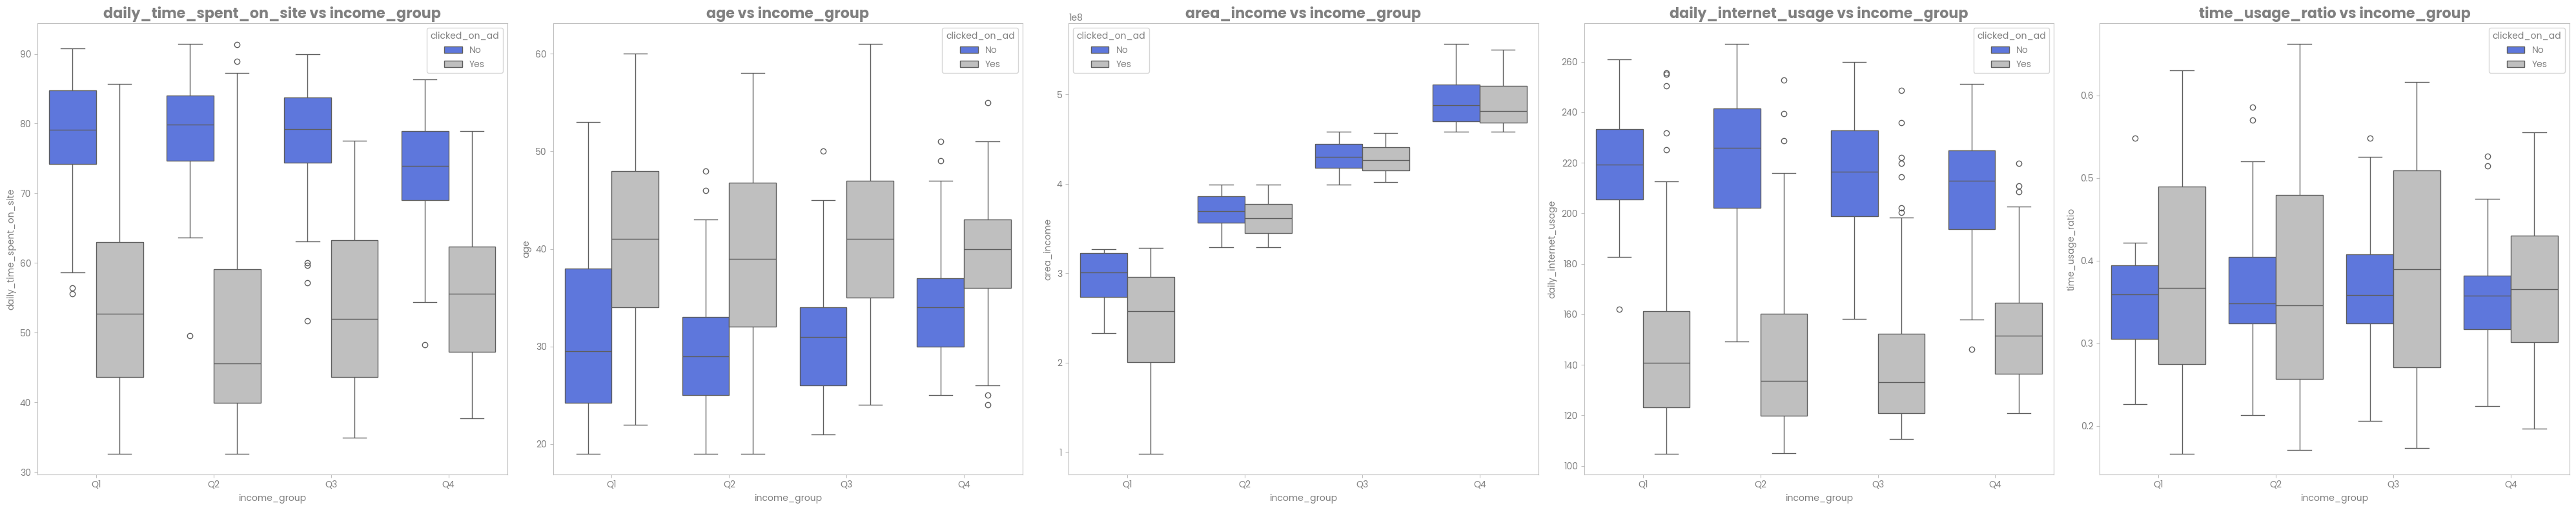

In [ ]:
categorical_cols = ["male", "category", "age_group", "income_group"]
numeric_cols = ["daily_time_spent_on_site", "age", "area_income", "daily_internet_usage", "time_usage_ratio"]

for cat in categorical_cols:
    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(8*len(numeric_cols), 8), sharey=False)

    for i, num in enumerate(numeric_cols):
        sns.boxplot(x=cat, y=num, hue="clicked_on_ad", data=df, ax=axes[i])
        axes[i].set_title(f"{num} vs {cat}", fontweight='bold', fontsize=16)
        axes[i].tick_params(axis="x", rotation=0)

    plt.tight_layout()
    plt.show()

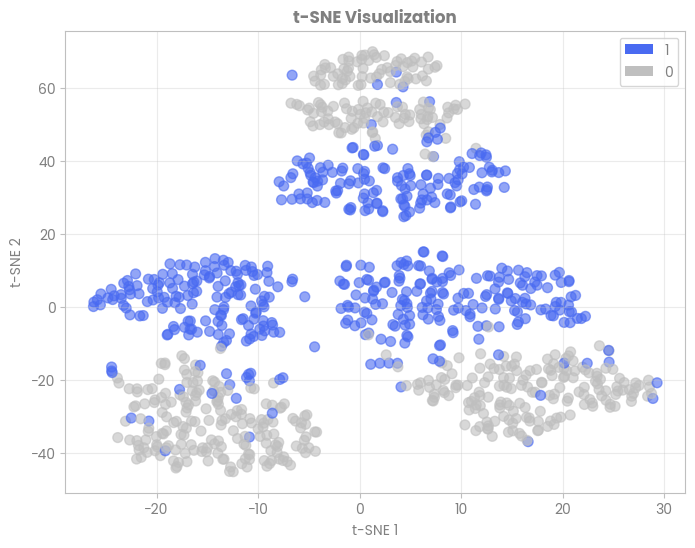

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Encode categorical variables
le_male = LabelEncoder()
le_category = LabelEncoder()
le_clicked = LabelEncoder()

df['male_encoded'] = le_male.fit_transform(df['male'].fillna('Unknown'))
df['category_encoded'] = le_category.fit_transform(df['category'])
df['clicked_encoded'] = le_clicked.fit_transform(df['clicked_on_ad'])

# Select features untuk clustering
feature_cols = ['daily_time_spent_on_site', 'age', 'area_income', 'daily_internet_usage', 'male_encoded', 'time_usage_ratio', 'hour', 'day_of_week', 'is_weekend', 'month', 'category_encoded']

# Ambil features dan target
X = df[feature_cols].copy()
y = df['clicked_encoded'].copy()
y_labels = df['clicked_on_ad'].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_color_map = {0: '#BFBFBF', 1: '#496af1'}
colors = [label_color_map[label] for label in y]

plt.figure(figsize=(8, 6))
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.6, s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization', fontweight='bold')
plt.grid(True, alpha=0.3)

legend_elements = [Patch(facecolor='#496af1', label=1), Patch(facecolor='#BFBFBF', label=0)]
plt.legend(handles=legend_elements)

plt.show()

In [ ]:
def cluster_profiling(df, cluster_col, num_cols, cat_cols):
    results = []
    clusters = df[cluster_col].unique()

    # Numerik
    for col in num_cols:
        # summary per cluster
        summary = df.groupby(cluster_col)[col].median().round(2).to_dict()

        # signifikansi
        groups = [df.loc[df[cluster_col] == c, col] for c in clusters]
        stat, p = kruskal(*groups)

        results.append({
            "Feature": col,
            "Type": "Numeric",
            "Summary": summary,
            "Test": "Kruskal-Wallis",
            "p_value": p
        })

    # Kategorikal
    for col in cat_cols:
        # summary proporsi
        summary = df.groupby(cluster_col)[col].agg(lambda x: x.mode().iloc[0]).to_dict()

        # signifikansi
        contingency = pd.crosstab(df[col], df[cluster_col])
        chi2, p, dof, exp = chi2_contingency(contingency)

        results.append({
            "Feature": col,
            "Type": "Categorical",
            "Summary": summary,
            "Test": "Chi-square",
            "p_value": p
        })

    return pd.DataFrame(results)

profiling = cluster_profiling(df, "clicked_on_ad", num_cols, cat_cols)
profiling.sort_values("p_value")

,Feature,Type,Summary,Test,p_value
3,daily_internet_usage,Numeric,"{'No': 216.02, 'Yes': 139.01}",Kruskal-Wallis,2.979016e-133
0,daily_time_spent_on_site,Numeric,"{'No': 77.46, 'Yes': 51.63}",Kruskal-Wallis,4.156907e-121
1,age,Numeric,"{'No': 31.0, 'Yes': 40.0}",Kruskal-Wallis,2.536453e-53
2,area_income,Numeric,"{'No': 435281665.0, 'Yes': 346928575.0}",Kruskal-Wallis,3.627648e-49
4,time_usage_ratio,Numeric,"{'No': 0.36, 'Yes': 0.36}",Kruskal-Wallis,1.504824e-01
12,city,Categorical,"{'No': 'Jakarta Timur', 'Yes': 'Bandung'}",Chi-square,2.062849e-01
5,male,Categorical,"{'No': 'Perempuan', 'Yes': 'Perempuan'}",Chi-square,2.961701e-01
11,province,Categorical,"{'No': 'Daerah Khusus Ibukota Jakarta', 'Yes':...",Chi-square,3.806313e-01
7,day_of_week,Categorical,"{'No': 4, 'Yes': 6}",Chi-square,6.426926e-01
10,category,Categorical,"{'No': 'Health', 'Yes': 'Otomotif'}",Chi-square,6.951549e-01
